### 차트만

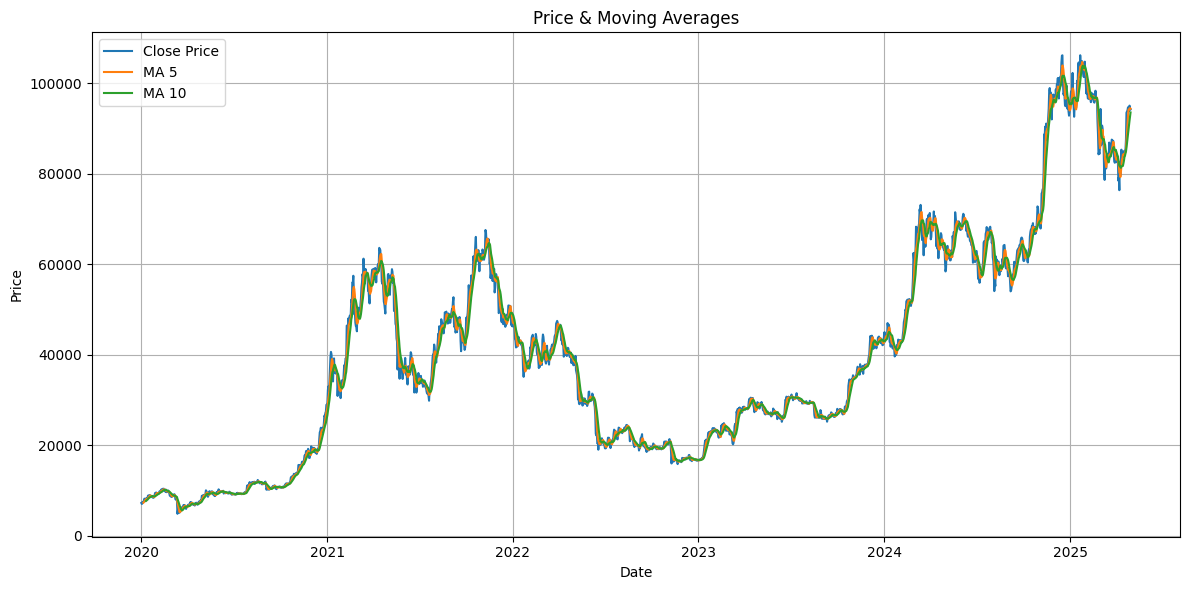

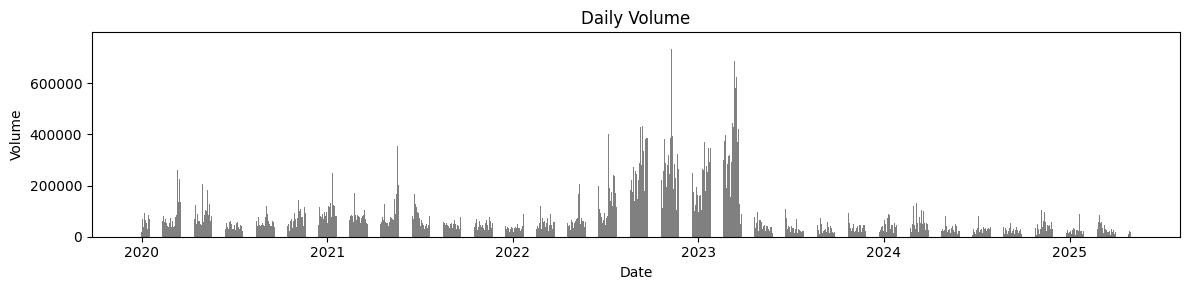

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) CSV 불러오기
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.set_index('date', inplace=True)
df_chart.sort_index(inplace=True)

# 2) 이동평균 컬럼 추가 (예: 5일, 10일)
df_chart['MA5'] = df_chart['close'].rolling(window=5).mean()
df_chart['MA10'] = df_chart['close'].rolling(window=10).mean()

# 3) 종가 및 이동평균 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_chart.index, df_chart['close'], label='Close Price')
plt.plot(df_chart.index, df_chart['MA5'], label='MA 5')
plt.plot(df_chart.index, df_chart['MA10'], label='MA 10')
plt.title('Price & Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) 거래량 시각화 (보조 차트)
plt.figure(figsize=(12, 3))
plt.bar(df_chart.index, df_chart['volume'], color='grey', width=0.6)
plt.title('Daily Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.tight_layout()
plt.show()


### 온체인만

In [8]:
import pandas as pd

# 1) CSV 불러오기
df_chain = pd.read_csv('./onchain/usdt_onchain_250101_250430.csv')

# 2) 숫자형으로 변환: "Value (USD)"에서 달러 기호와 쉼표 제거 후 float 변환
df_chain['Value_USD'] = df_chain['Value (USD)'].str.replace(r'[$,]', '', regex=True).astype(float)
df_chain['Amount'] = pd.to_numeric(df_chain['Amount'], errors='coerce')

# 3) 전체 트랜잭션 개수와 총 전송 금액 (USD) 계산
total_txns = len(df_chain)
total_volume_usd = df_chain['Value_USD'].sum()

print(f"전체 트랜잭션 건수: {total_txns}")
print(f"총 전송 금액 (USD): {total_volume_usd:,.2f}")

# 4) Asset별 요약 통계 (트랜잭션 건수, 합계)
asset_summary = df_chain.groupby('Asset').agg(
    txns_count=('Transaction Hash', 'count'),
    total_usd=('Value_USD', 'sum'),
    total_amount=('Amount', 'sum')
).reset_index()

print("\n=== Asset별 요약 ===")
print(asset_summary)

# 5) 상위 10개 큰 트랜잭션 (USD 기준) 조회
top10 = df_chain.nlargest(10, 'Value_USD')[['Transaction Hash', 'From', 'To', 'Value_USD']]
print("\n=== 상위 10개 트랜잭션 (USD 기준) ===")
print(top10)

# 6) 주요 지갑(From/To)별 누적 전송 USD 합계
from_summary = df_chain.groupby('From').agg(
    total_sent_usd=('Value_USD', 'sum'),
    txns_count=('Transaction Hash', 'count')
).reset_index().sort_values('total_sent_usd', ascending=False).head(10)

to_summary = df_chain.groupby('To').agg(
    total_received_usd=('Value_USD', 'sum'),
    txns_count=('Transaction Hash', 'count')
).reset_index().sort_values('total_received_usd', ascending=False).head(10)

print("\n=== 상위 10개 발신(From) 지갑 ===")
print(from_summary)
print("\n=== 상위 10개 수신(To) 지갑 ===")
print(to_summary)


AttributeError: Can only use .str accessor with string values!

### 차트 + 온체인 혼합

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 차트 데이터 불러오기
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.set_index('date', inplace=True)
df_chart.sort_index(inplace=True)

# 2) 온체인 데이터 불러오기 (여기서는 이미 'Date' 컬럼이 있는 것으로 가정)
df_chain = pd.read_csv('./onchain/usdt_onchain_250101_250430.csv', parse_dates=['Date'])

# 3) 온체인 데이터를 일별 합계(USD 기준)로 집계
df_chain['Value_USD'] = df_chain['Value (USD)'].str.replace(r'[$,]', '', regex=True).astype(float)
daily_chain = df_chain.groupby(df_chain['Date'].dt.floor('D')).agg(
    daily_txns_count=('Transaction Hash', 'count'),
    daily_total_usd=('Value_USD', 'sum')
).rename_axis('date').reset_index()

# 4) 차트 데이터와 온체인 집계 데이터 병합
#    df_chart에는 index로 date가 있고, daily_chain은 컬럼 'date'를 가진 상태
merged = df_chart.reset_index().merge(daily_chain, on='date', how='inner')
merged.set_index('date', inplace=True)

# 5) 상관관계 계산
corr_price_volume = merged['close'].corr(merged['daily_total_usd'])
print(f"종가와 일별 온체인 USD 합계 간 상관계수: {corr_price_volume:.4f}")

# 6) 시각화: 한 플롯에 Price와 온체인 USD 합계 (스케일 차이가 크므로 보조축 사용)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(merged.index, merged['close'], color='tab:blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(merged.index, merged['daily_total_usd'], color='tab:red', label='On-chain USD Sum')
ax2.set_ylabel('Daily On-chain USD Sum', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Close Price vs Daily On-chain USD Sum')
fig.tight_layout()
plt.show()

# 7) 산점도(Scatter)으로도 확인
plt.figure(figsize=(6, 6))
plt.scatter(merged['daily_total_usd'], merged['close'], alpha=0.7)
plt.title('Scatter: On-chain USD Sum vs Close Price')
plt.xlabel('Daily On-chain USD Sum')
plt.ylabel('Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()
